# Step 1: Install and Import Libraries

In [1]:
# Install libraries
!pip install yfinance prophet

In [2]:
# Data processin# Import libraries
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

# Step 2: Pull Data

In [3]:
# Load data and preprocess
file_path = '/content/data_kelompok.xlsx'
data = pd.read_excel(file_path)

# Rename columns for Prophet
data = data.rename(columns={'Tanggal': 'ds', 'Penumpang': 'y'})

# Convert columns to appropriate types
data['ds'] = pd.to_datetime(data['ds'])
data['y'] = data['y'].astype(float)


In [4]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      550 non-null    datetime64[ns]
 1   y       550 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


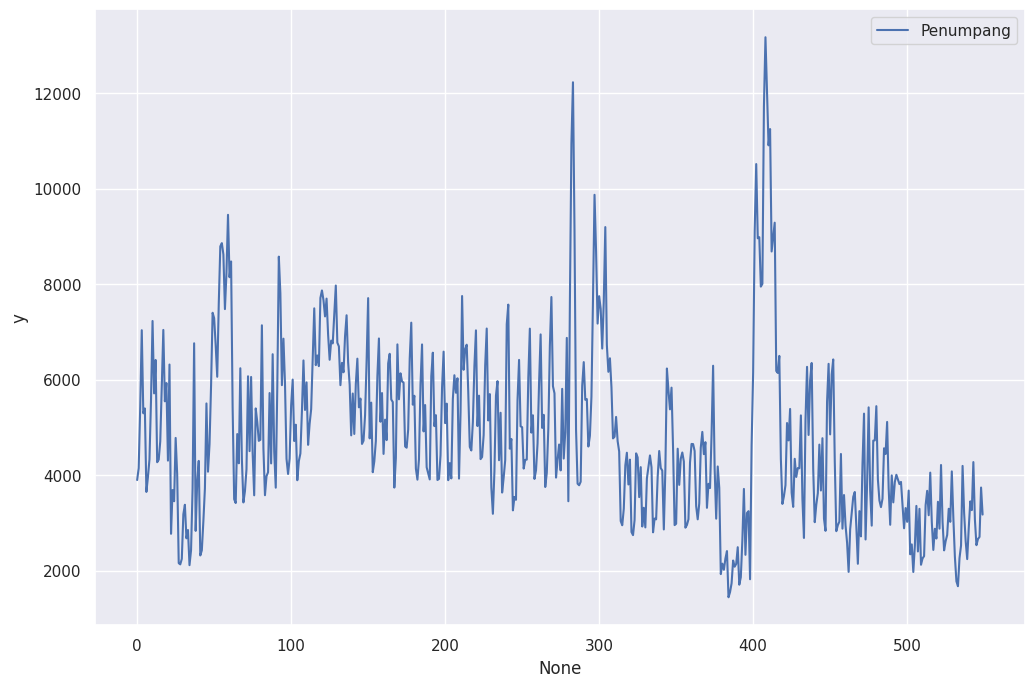

In [5]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['y'])
plt.legend(['Penumpang'])

# Step 3: Train Test Split

In [6]:
# Split into train and test data
train_data = data[:321]  # Data latih
test_data = data[321:]   # Data uji

# Check the shape of the dataset
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (321, 2)
Test data shape: (229, 2)


# Step 4: Model Seasonal


## Step 4.1: Build Model with Seasonal

In [7]:

# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.1],
    'seasonality_prior_scale': [10],
    'seasonality_mode': ['additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Create a list to store MAPE values for each combination
mapes = []

for params in all_params:

    # Fit a model using one parameter combination
    m = Prophet(**params).fit(train_data)

    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon='60 days', parallel="processes")

    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)

    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

# Save the tuning results to an Excel file
tuning_results.to_excel("tuning_results.xlsx", index=False)

# Print the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zyyz9nx/5jk988mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zyyz9nx/ppl8xwyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31626', 'data', 'file=/tmp/tmp0zyyz9nx/5jk988mj.json', 'init=/tmp/tmp0zyyz9nx/ppl8xwyu.json', 'output', 'file=/tmp/tmp0zyyz9nx/prophet_modelg7jtbytg/prophet_model-20241122144227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cut

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'seasonality_mode': 'additive'}


In [8]:
auto_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

auto_model.add_seasonality(name='weekly', period=7, fourier_order=3)  # Musiman tambahan

# Fit the model on the training dataset
auto_model.fit(train_data)

# Cross-validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon='60 days', parallel="processes")

# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
print("Cross-Validation MAPE (Train):", auto_model_p['mape'].values[0])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zyyz9nx/1ns44ncq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zyyz9nx/5qe9nfzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7948', 'data', 'file=/tmp/tmp0zyyz9nx/1ns44ncq.json', 'init=/tmp/tmp0zyyz9nx/5qe9nfzm.json', 'output', 'file=/tmp/tmp0zyyz9nx/prophet_modelyi7gu8zj/prophet_model-20241122144233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:33 - cmdstanpy - INFO - Chain [1] don

Cross-Validation MAPE (Train): 0.15252662692487806


In [9]:
# Create future DataFrame for predictions
# Adjust the number of periods as needed (e.g., for the next 60 days)
future = auto_model.make_future_dataframe(periods=229)

# Make predictions
forecast = auto_model.predict(future)

# Calculate MAPE on test data
test_forecast = forecast.set_index('ds').loc[test_data['ds']]
mape_test = mape(test_data['y'], test_forecast['yhat'])
print("MAPE on Test Data:", mape_test)



MAPE on Test Data: 0.651716259257389


In [ ]:
# Pilih kolom yang ingin disimpan
forecast_229_days = forecast.tail(229)[['ds', 'yhat']]  # Hanya tanggal dan nilai prediksi
forecast_229_days.to_excel("forecast_229_days.xlsx", index=False)

print("Forecast (yhat) for 229 days ahead has been saved to 'forecast_229_days.xlsx'")


Forecast (yhat) for 229 days ahead has been saved to 'forecast_229_days.xlsx'


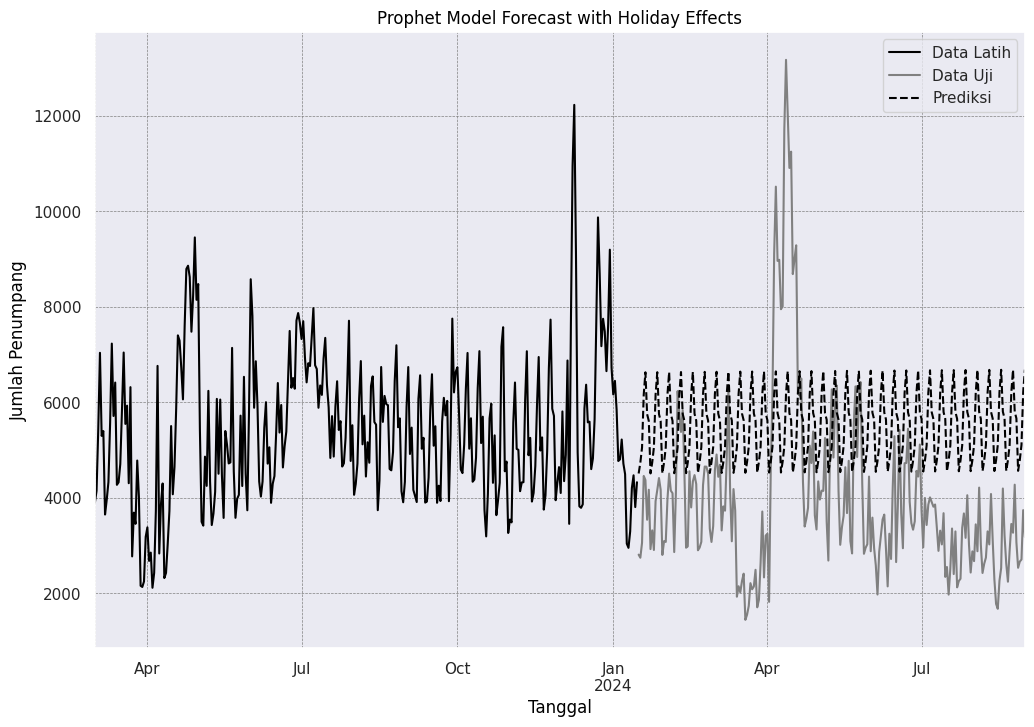

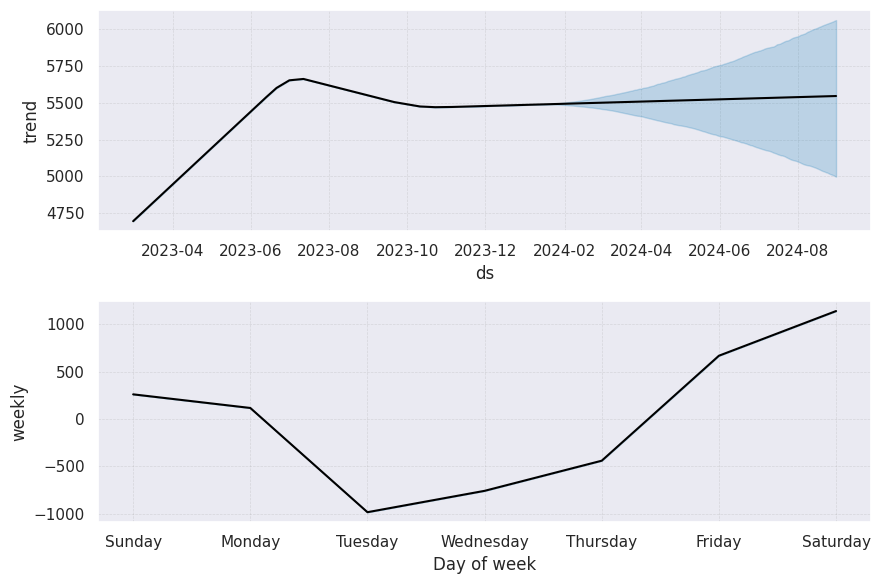

In [10]:
import matplotlib.pyplot as plt

# Plot forecast results with holiday effects for test data
fig, ax = plt.subplots(figsize=(12, 8))
train_data.plot(x='ds', y='y', ax=ax, label='Data Latih', color='black', linestyle='-')
test_data.plot(x='ds', y='y', ax=ax, label='Data Uji', color='gray', linestyle='-')
test_forecast.plot(y='yhat', ax=ax, label='Prediksi', color='black', linestyle='--')
plt.legend(['Data Latih', 'Data Uji', 'Prediksi'])
plt.title('Prophet Model Forecast with Holiday Effects', color='black')
plt.xlabel('Tanggal', color='black')
plt.ylabel('Jumlah Penumpang', color='black')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

# Plot forecast components to see holiday effects
fig2 = auto_model.plot_components(forecast)
for ax in fig2.axes:
    for line in ax.lines:
        line.set_color('black')  # Change all lines to black
        if '--' in line.get_linestyle():  # Ensure dashed line for forecast components if applicable
            line.set_linestyle('--')
    ax.grid(color='gray', linestyle='--', linewidth=0.5)  # Grid lines in gray and dashed
plt.show()


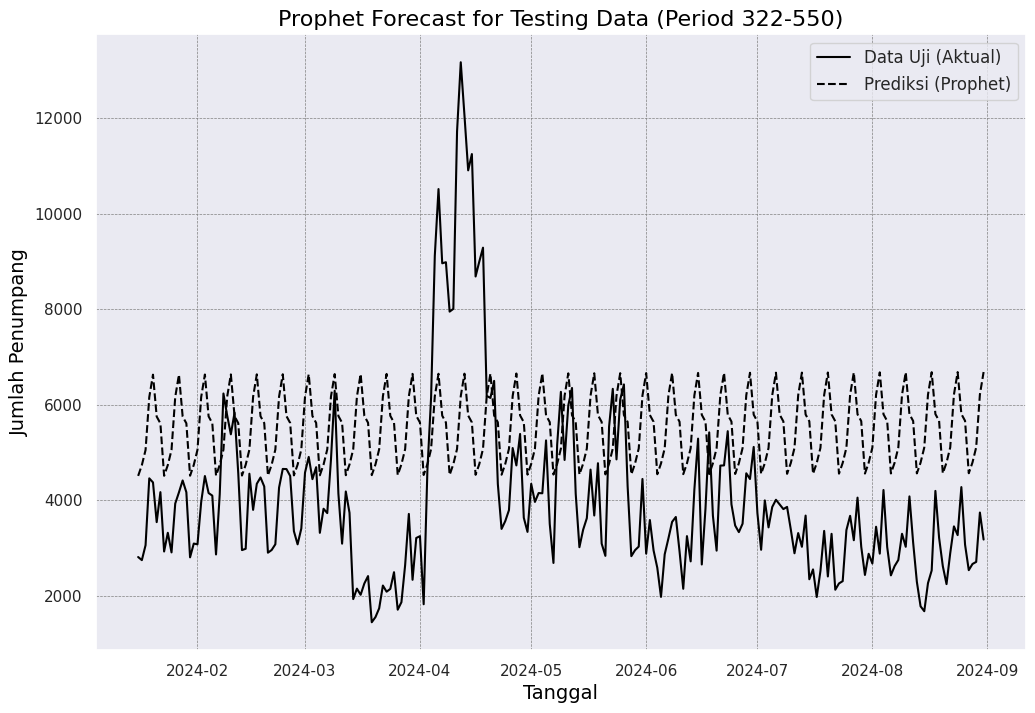

In [11]:
import matplotlib.pyplot as plt

# Filter data uji dari hasil prediksi
forecast_test = forecast.iloc[321:550]  # Ambil periode 322-550 (data uji)
test_actual = test_data.reset_index()  # Reset index untuk mencocokkan dengan forecast

# Plot data uji dan prediksi
fig, ax = plt.subplots(figsize=(12, 8))

# Data uji aktual
plt.plot(test_actual['ds'], test_actual['y'], label='Data Uji (Aktual)', color='black', linestyle='-')

# Prediksi Prophet
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prediksi (Prophet)', color='black', linestyle='--')

# Tambahkan legend, title, dan label
plt.legend(fontsize=12)
plt.title('Prophet Forecast for Testing Data (Period 322-550)', fontsize=16, color='black')
plt.xlabel('Tanggal', fontsize=14, color='black')
plt.ylabel('Jumlah Penumpang', fontsize=14, color='black')

# Tambahkan grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Tampilkan plot
plt.show()

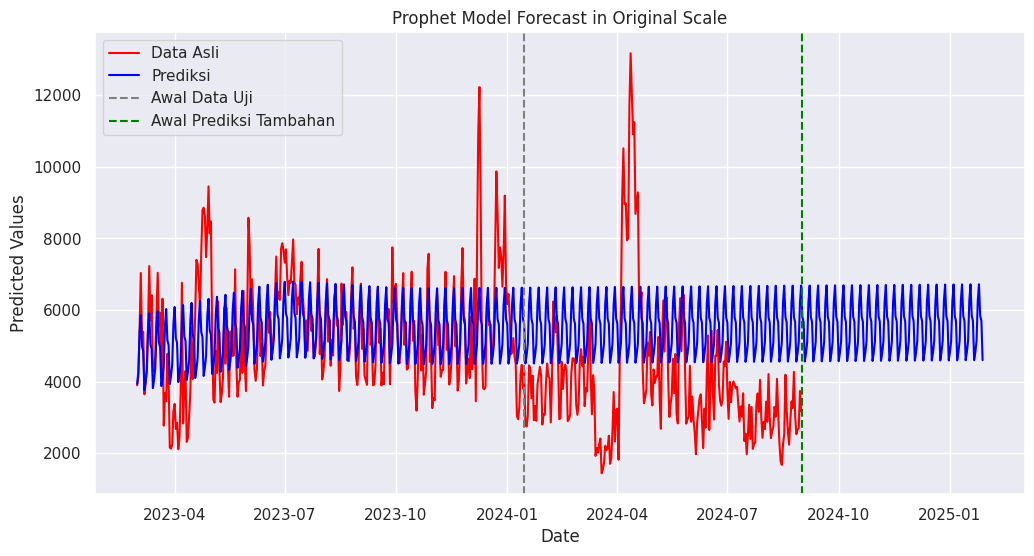

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Extend future prediction by 300 additional periods after test data
future_all = auto_model.make_future_dataframe(periods=229 + 150)

# Predict future values
forecast_all = auto_model.predict(future_all)

# Plot original data, train/test data, and future forecast
plt.figure(figsize=(12, 6))

# Plot the actual data (train + test combined)
plt.plot(data['ds'], data['y'], label='Data Asli', color='red')

# Plot the forecasted values
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Prediksi', color='blue')

# Highlight the beginning of test data and additional forecast period
plt.axvline(x=train_data['ds'].iloc[-1], color='gray', linestyle='--', label='Awal Data Uji')
plt.axvline(x=future_all['ds'].iloc[-150], color='green', linestyle='--', label='Awal Prediksi Tambahan')

# Add labels and title
plt.title('Prophet Model Forecast in Original Scale')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()